In [2]:
## Setup Imports

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm 

import jax
import jax.numpy as jnp
from jax import jit, vmap, value_and_grad
import optax

from typing import NamedTuple, Tuple, List
import functools
import copy

rng = jax.random.PRNGKey(42)

from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader

####Data Loader

In [3]:
class MNIST_Dataset(Dataset):
    """
    A custom dataset class that returns a pair of positive and negative image
    samples as defined in the paper. 
    """
    def __init__(self, train):
        super().__init__()

        self.train = train
        self.base_dataset = MNIST(root='train_mnist', download=True, train=train)

    def __len__(self):
        return len(self.base_dataset)
    
    def __getitem__(self, index: int):
        # This function encodes the label within the image to make the data samples. 
        # For this example, as MNIST has 10 labels, we take the top-left corner's first
        # 10 pixels and encode one-hot representation of the label into these 10 pixels.

        # Load the base image and label
        img = self.base_dataset[index][0]
        label = self.base_dataset[index][1]

        # Flatten the image and set the first 10 bits as 0
        img = np.ravel(np.array(img, dtype=np.float32))
        img[:10] = 0
        
        if self.train:
            # Create a positive sample by setting the current label index as 255
            # For example, if the label is '5', we set the 5th pixel to 255
            pos_img = img.copy()
            pos_img[label] = img.max()

            # Create a negative sample by setting a random index in [0 -> 10]
            # which is not the correct label as 255
            neg_img = img.copy()
            random_label = np.random.choice(np.setdiff1d(list(range(0, 10)), [label]))
            neg_img[random_label] = img.max()

            return img, pos_img, neg_img, label
        else:
            return img, label

In [4]:
"""
A custom dataloader collate function to create batches of positive and negative data.
Returns as jax array instead of the default pytorch tensor
"""
def train_collate_fn(batch):
    transposed_data = list(zip(*batch))
    imgs = jnp.array(transposed_data[0])
    pos_imgs = jnp.array(transposed_data[1])
    neg_imgs = jnp.array(transposed_data[2])
    true_labels = jnp.array(transposed_data[3])

    return imgs, pos_imgs, neg_imgs, true_labels

def test_collate_fn(batch):
    transposed_data = list(zip(*batch))
    imgs = jnp.array(transposed_data[0])
    true_labels = jnp.array(transposed_data[1])

    return imgs, true_labels

mnist_train = MNIST_Dataset(train=True)
mnist_test = MNIST_Dataset(train=False)

# Load the whole dataset into memory for custom batching
train_loader = DataLoader(mnist_train, len(mnist_train), shuffle=True, collate_fn=train_collate_fn, drop_last=True)
test_loader = DataLoader(mnist_test, len(mnist_test), shuffle=False, collate_fn=test_collate_fn, drop_last=True)

In [5]:
train_imgs, train_pos_xs, train_neg_xs, train_labels = next(iter(train_loader))
test_xs, test_labels = next(iter(test_loader))

print("Train xs shape: ", train_pos_xs.shape)
print("Test x, y shape: ", test_xs.shape, test_labels.shape)

Train xs shape:  (60000, 784)
Test x, y shape:  (10000, 784) (10000,)


4 Random training samples and labels


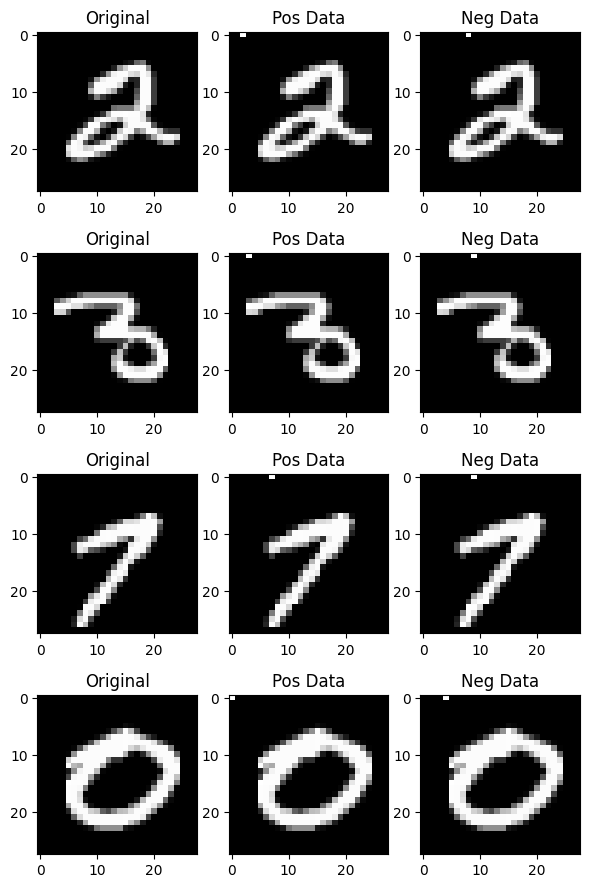

In [6]:
print("4 Random training samples and labels")
indxs = [5, 30, 79, 114]

plt.figure(figsize=(7, 11))

for i, idx in enumerate(indxs):
    i *= 3
    img, pos_img, neg_img, label = mnist_train[idx]

    plt.subplot(4, 3, i + 1)
    plt.imshow(img.reshape((28, 28)), cmap="gray")
    plt.title("Original")

    plt.subplot(4, 3, i + 2)
    plt.imshow(pos_img.reshape((28, 28)), cmap="gray")
    plt.title("Pos Data")

    plt.subplot(4, 3, i + 3)
    plt.imshow(neg_img.reshape((28, 28)), cmap="gray")
    plt.title("Neg Data")

plt.show()

####Model

In [7]:
"""
Here we define a custon Linear layer for the model. Each layer contains its
own weights, biases, and also the optimizer state. Since each layer is trained
locally without any backward pass, the optimizer does loacl optimizer for each
layer independently.
"""

class LayerState(NamedTuple):
    params: Tuple[jnp.ndarray, jnp.ndarray]
    opt_state: Tuple


def init_layer_state(in_dim, out_dim, PRNGkey, opt, scale=1e-3) -> LayerState:
    """
    Initialize the layer weights, biases, and optimizer state
    """
    initializer = jax.nn.initializers.glorot_uniform()

    weights_key, bias_key = jax.random.split(PRNGkey)
    weights = initializer(weights_key, (out_dim, in_dim), jnp.float32) * scale
    biases = jax.random.normal(bias_key, (out_dim, ), jnp.float32) * scale
    opt_state = opt.init((weights, biases))

    return LayerState((weights, biases), opt_state)

In [8]:
class Layer:
    """
    Stateless layer namespace that contains the functions for training layers.
    """

    def forward(params: Tuple, x: jnp.ndarray):
        """
        params: Tuple of (weights, biases) of the current layer
        x: input array

        This function performs a forward pass for a single flattened input.
        The input is first normalized, and linearly transformed using the
        layer weights and bias. Finally, it is non-liniearized using ReLU activation
        """ 
        x /= (jnp.sqrt(jnp.mean(x ** 2, axis=-1, keepdims=True)) + 1e-6)

        w, b = params
        return jax.nn.relu(jnp.dot(w, x) + b)

    
    ## Batchify the forward function
    @functools.partial(jax.vmap, in_axes=(None, 0)) # Batch dim 0
    def b_forward(params: Tuple, xs: jnp.ndarray):
        return Layer.forward(params, xs)
    

    def goodness(params: Tuple, x: jnp.ndarray):
        """
        Calculates the sum squared goodness for a single input as 
        mentioned in the paper. It first gets the activation of the current layer
        for the input, and then takes the L2 norm of the activations
        """

        h = Layer.forward(params, x)  
        return jnp.power(h, 2).sum(), h

    ## Batchify the goodness function
    @functools.partial(jax.vmap, in_axes=(None, 0)) # Batch dim 0
    def b_goodness(params: Tuple, xs: jnp.ndarray):
        return Layer.goodness(params, xs)

    """
    The main Forward-Forward algorithm is below. We first get the goodness value
    for all positive and negative samples respectively.
    The custom loss function finds the distance between the Mean-squared
    result and the threshold value which we set as the length of the input vector.
    The loss is calculated as a mean across the entire batch combining both the 
    positive and negative data.
    """
    def forward_forward(params: Tuple, pos_xs: jnp.ndarray, neg_xs: jnp.ndarray):
        """
        pos_xs : batch of positive inputs - (batch_size, 784)
        neg_xs : batch of negative inputs - (batch_size, 784)
        """

        pos_goodness, _ = Layer.b_goodness(params, pos_xs)
        neg_goodness, _ = Layer.b_goodness(params, neg_xs)

        pos_logits = pos_goodness - pos_xs.shape[-1]
        neg_logits = neg_goodness - neg_xs.shape[-1]
        
        loss = -jax.nn.log_sigmoid(jnp.concatenate([pos_logits, -neg_logits])).mean()
        
        return loss

####Utils

In [9]:
# Utility Functions

def plot_image(inputs, idx=0):
    print("Embedded Label:",  np.argmax(inputs[idx][:10]))
    im = inputs[idx].reshape(28, 28)
    plt.figure(figsize = (4, 4))
    plt.imshow(im, cmap="gray")
    plt.show()

def batch(arr, batch_size):
  for i in range(0, len(arr), batch_size):
    yield arr[i: i+batch_size]

In [10]:
"""
We implement hard-negative mining over the number of episodes.
At the end of episodes we replace the original negative samples using hard-mined
samples. For this, we evaluate each image using the current trained model and 
set the negative label as the second most probable label predicted by the model
for that image. This allows the model to better differentiate between positive 
and negative samples which was mentioned in the paper as an extension.
"""
def get_negative_label(params, x):
    goodnesses = jnp.zeros(10)
    label = jnp.argmax(jnp.split(x, [10])[0])
    for query_label in range(10):
        img = jnp.array(x.copy())
        img = img.at[query_label].set(img.max())
        for layer_params in params:
            g, img = Layer.goodness(layer_params, img)
            goodnesses = goodnesses.at[query_label].add(g)
            
    # get negative label that gives second best goodness
    label_top2 = jax.lax.top_k(goodnesses, 2)[1]
    
    neg_label = label_top2[1]
    neg_img = jnp.array(x.copy())
    neg_img = neg_img.at[label].set(0)  # zero the positive label
    neg_img = neg_img.at[neg_label].set(neg_img.max())
    return neg_img

def get_hard_negs(params, xs):
    b_get_negative_label = vmap(get_negative_label, in_axes=(None, 0))
    neg_images = b_get_negative_label(params, xs)

    return neg_images

In [11]:
"""
Function to predict the label for a single input image. It follows the
method outlined in the paper which queries over all the labels
and calculates the sum of goodness for all the layers. The label that 
gives the highest goodness is the predicted output.
"""
def predict_one_sample(params, x):
    goodnesses = jnp.zeros(10)
    for query_label in range(10):
        img = jnp.array(x.copy())
        img = img.at[query_label].set(img.max())
        for layer_params in params:
            g, img = Layer.goodness(layer_params, img)
            goodnesses = goodnesses.at[query_label].add(g)

    return jnp.argmax(goodnesses)

"""
Calculates accuracy over the whole dataset
"""
def accuracy(params, xs, ys):
    b_predict = vmap(predict_one_sample, in_axes=(None, 0))
    y_hats = b_predict(params, xs)

    if ys.shape[-1] == 10:
        labels = jnp.argmax(ys, axis=-1)
    else:
        labels = ys

    return jnp.mean(labels == y_hats)

####Training

In [12]:
"""
This function trains a single layer for the specified number of epochs.
For each step, it takes a batch of positive and negative imagesand passes them
through the layer's forward_forward function that returns the loss for that batch
of data. The optimizer takes the gradients over the loss and updates the parameters
of the layer. This is not counted as backpropagation because the gradients are not
passed through any other layer, and the updates happen locally.
"""
def train_layer(
        opt: optax.GradientTransformation,
        num_epochs: int,
        batch_size: int,
        initial_state: LayerState,
        layer_idx: int,
        pos_xs: np.ndarray,
        neg_xs: np.ndarray):
    
    @jit
    def step(state: LayerState, pos_xs, neg_xs):
        # Get the loss and gradients for the current batch of data
        # and update the layer parameters
        loss, grads = value_and_grad(Layer.forward_forward)(state.params, pos_xs, neg_xs)
        updates, opt_state = opt.update(grads, state.opt_state)
        params = optax.apply_updates(state.params, updates)
        return loss, LayerState(params, opt_state)

    # Collects the loss over each epoch
    loss_hist = []

    # Gets a batch of positive and negative data
    pos_batches = list(batch(pos_xs, batch_size))
    neg_batches = list(batch(neg_xs, batch_size))

    state = initial_state

    pbar = tqdm(range(num_epochs), desc=f"Training Layer {layer_idx}")
    for epoch in pbar:
        loss_sum = 0.
        for pos_batch, neg_batch in zip(pos_batches, neg_batches):
            loss, state = step(state, pos_batch, neg_batch)
            loss_sum += loss
        loss_hist.append(float(loss_sum))
        pbar.set_postfix({'loss': loss_sum})
    
    # Return the updated and trained layer state
    return state, loss_hist

In [14]:
"""
Trains all the layers of the model for a fixed number of episodes.
Each layer is trained for num_epochs, and the whole model is trained over 
num_episodes. Hard-negative mining is used in-between episodes to improve
generalization. 
"""
def train_net(
    opt: optax.GradientTransformation,
    num_epochs: int,
    batch_size: int,
    initial_states: List[LayerState],
    pos_xs: np.ndarray,
    neg_xs: np.ndarray,
    num_episodes: int):

    # Collects the loss history over all episodes
    loss_all = []

    pos_in = copy.deepcopy(pos_xs)
    neg_in = copy.deepcopy(neg_xs)

    for i in range(num_episodes):
        print(f"Start training episode {i+1}.")

        final_states = []
        loss_hists = []
        for layer_idx, layer_state in enumerate(initial_states):
            final_state, loss_hist = train_layer(opt, num_epochs, batch_size, layer_state, layer_idx, pos_xs, neg_xs)
            final_states.append(final_state)
            loss_hists.append(loss_hist)
            pos_xs = Layer.b_forward(final_state.params, pos_xs)
            neg_xs = Layer.b_forward(final_state.params, neg_xs)
        
        loss_all.append(loss_hists)
        
        # Evaluate at the end of episode
        train_acc = accuracy([s.params for s in final_states], train_imgs, train_labels)
        print("Train Accuracy: ", train_acc)
        test_acc = accuracy([s.params for s in final_states], test_xs, test_labels)
        print("Test Accuracy: ", test_acc)

        # Re-assign parameters for next episode
        initial_states = final_states

        # Re-assign positive data as previous
        # Update negative data with hard-mining
        pos_xs = pos_in
        neg_xs = get_hard_negs([s.params for s in final_states], train_imgs)

    # Returns the final trained states of all layers
    return final_states, loss_all

####Run

In [17]:
lr = 0.001
rng = jax.random.PRNGKey(39)
opt = optax.sgd(lr)
n_epochs = 60
n_episodes = 3
batch_size = 100

states = [
    init_layer_state(784, 512, rng, opt, scale=1),
    init_layer_state(512, 512, rng, opt, scale=1),
    init_layer_state(512, 512, rng, opt, scale=1),
]

states, loss_hists = train_net(opt, n_epochs, batch_size, states, train_pos_xs, train_neg_xs, n_episodes)

Start training episode 1.


Training Layer 0:   0%|          | 0/60 [00:00<?, ?it/s]

Training Layer 1:   0%|          | 0/60 [00:00<?, ?it/s]

Training Layer 2:   0%|          | 0/60 [00:00<?, ?it/s]

Train Accuracy:  0.95491666
Test Accuracy:  0.9517
Start training episode 2.


Training Layer 0:   0%|          | 0/60 [00:00<?, ?it/s]

Training Layer 1:   0%|          | 0/60 [00:00<?, ?it/s]

Training Layer 2:   0%|          | 0/60 [00:00<?, ?it/s]

Train Accuracy:  0.9710167
Test Accuracy:  0.96709996
Start training episode 3.


Training Layer 0:   0%|          | 0/60 [00:00<?, ?it/s]

Training Layer 1:   0%|          | 0/60 [00:00<?, ?it/s]

Training Layer 2:   0%|          | 0/60 [00:00<?, ?it/s]

Train Accuracy:  0.97643334
Test Accuracy:  0.97239995


In [ ]:
"""
## Conclusion

With the help of the JAX, this example has shown how the Forward-Forward algorithm works.
With a 2000-unit, 4-hidden-layer, fully-connected network run over 60 epochs, Geoffrey Hinton 
reported test accuracy error results of 1.36% in the paper. He also noted that backpropagation 
only needs 20 epochs to reach a comparable level of performance. A second run with the learning 
rate doubled and 40 training epochs results in a marginally higher error rate of 1.46%.
With 3 layers of 512 hidden units, the present example produces a 1.8% test accuracy error 
after 5 episodes and 60 epochs. The findings can be improved to match the claims of the paper 
with proper tuning of the Learning Rate, model architecture (number of units in "Dense" layers, 
kernel activations, initializations, regularization, etc.), and other factors.
"""